In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from diffusers import UNet2DModel
from torchvision import datasets, transforms
import os
import warnings
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [2]:
if torch.backends.mps.is_available():
    device =  torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

mps


# pretrained model

In [3]:
model= UNet2DModel.from_pretrained("1aurent/ddpm-mnist").to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [4]:
# (Stanczuk et al. 2022)
def get_spectrum_standard(model, x0, t_index, device, epsilon=1e-3, batch_size=128):
    model.eval()
    d = x0.numel()
    
    perturbations = torch.randn(d, *x0.shape[1:], device=device)
    perturbations = perturbations / perturbations.view(d, -1).norm(dim=1, keepdim=True).view(d, 1, 1, 1)
    
    x0_expanded = x0.expand(d, -1, -1, -1)
    x_perturbed = x0_expanded + epsilon * perturbations
    t_tensor = torch.full((d,), t_index, device=device, dtype=torch.long)

    outputs = []
    with torch.no_grad():
        for i in range(0, d, batch_size):
            end = min(i + batch_size, d)
            out = model(x_perturbed[i:end], t_tensor[i:end]).sample
            outputs.append(out)
            
    eps_out = torch.cat(outputs, dim=0)
    
    with torch.no_grad():
        score_x0 = model(x0, torch.tensor([t_index], device=device)).sample
    
    diff = (eps_out - score_x0) / epsilon
    jacobian_matrix = diff.view(d, -1).cpu()
    
    _, S, _ = torch.linalg.svd(jacobian_matrix, full_matrices=False)
    S_np = S.numpy()
    
    return S_np / S_np.max() if S_np.max() > 0 else S_np


# méthode du papier
def get_spectrum_orthogonalized(model, x0, t_index, device, epsilon=1e-3, batch_size=128):
    model.eval()
    d = x0.numel()
    
    noise_matrix = torch.randn(d, d, device='cpu')
    q, _ = torch.linalg.qr(noise_matrix)
    q = q.to(device)
    perturbations = q.view(d, *x0.shape[1:])
    
    x0_expanded = x0.expand(d, -1, -1, -1)
    x_pos = x0_expanded + epsilon * perturbations
    x_neg = x0_expanded - epsilon * perturbations
    t_tensor = torch.full((d,), t_index, device=device, dtype=torch.long)

    outputs_pos, outputs_neg = [], []
    with torch.no_grad():
        for i in range(0, d, batch_size):
            end = min(i + batch_size, d)
            out_p = model(x_pos[i:end], t_tensor[i:end]).sample
            out_n = model(x_neg[i:end], t_tensor[i:end]).sample
            outputs_pos.append(out_p)
            outputs_neg.append(out_n)
            
    eps_pos = torch.cat(outputs_pos, dim=0)
    eps_neg = torch.cat(outputs_neg, dim=0)
    
    diff = (eps_pos - eps_neg) / 2 ###
    jacobian_matrix = diff.view(d, -1).cpu()
    
    _, S, _ = torch.linalg.svd(jacobian_matrix, full_matrices=False)
    S_np = S.numpy()
    
    return S_np / S_np.max() if S_np.max() > 0 else S_np

# figure 9 de l'article

Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 26.52it/s]


t = 0...
t = 1...
t = 2...
t = 5...
t = 10...
t = 15...
t = 20...
t = 25...
t = 50...
t = 100...
t = 200...
t = 800...
t = 990...


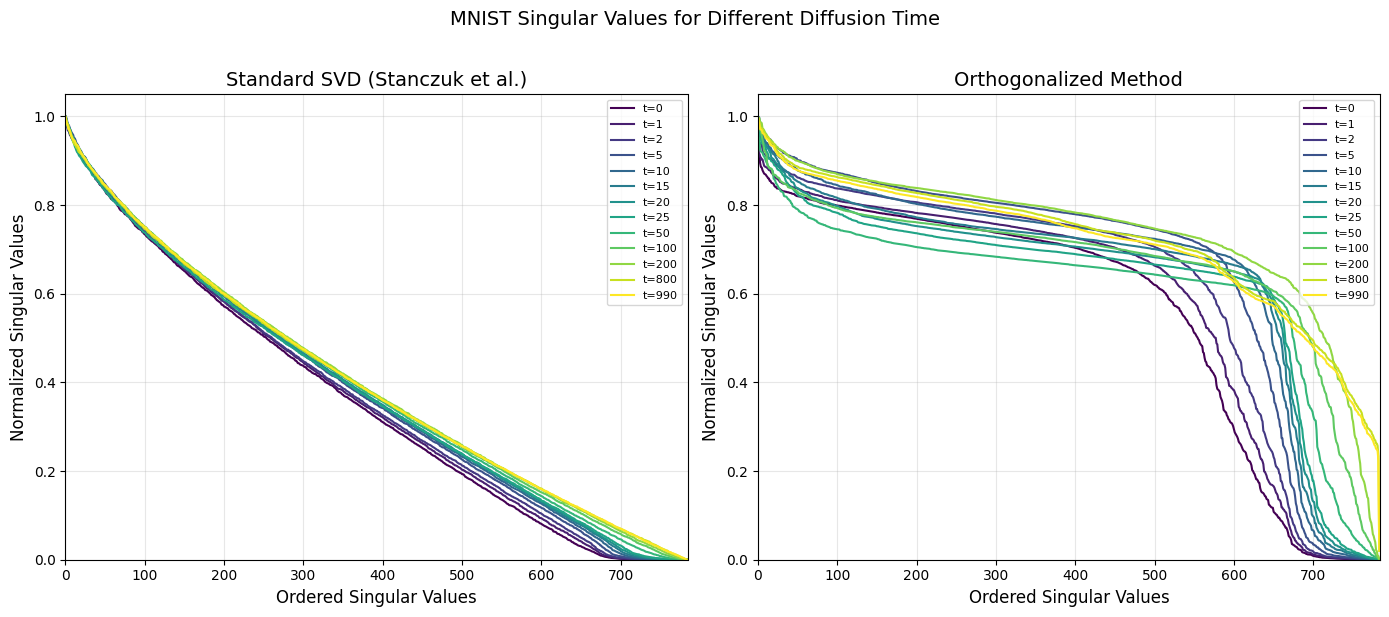

In [11]:
# Figure 9
from diffusers import DDPMPipeline
image, label = dataset[0]
image = image.unsqueeze(0).to(device)

times = [0, 1, 2, 5, 10, 15, 20, 25, 50, 100, 200, 800, 990]

pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist").to(device)
scheduler = pipe.scheduler

alpha_bar = scheduler.alphas_cumprod[1].to(image.dtype).view(-1, 1, 1, 1)
sigma_t = torch.sqrt(1.0 - alpha_bar)
    
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
cmap = plt.cm.viridis(np.linspace(0, 1, len(times)))

d = image.numel()

for t, color in zip(times, cmap):
    print(f"t = {t}...")
    
    # Méthode standard
    spectrum_std = get_spectrum_standard(model, image, t, device)
    # X = indices ordonnés (0 à d-1), Y = valeurs singulières normalisées
    axes[0].plot(np.arange(len(spectrum_std)), spectrum_std, 
                    color=color, lw=1.5, label=f't={t}')
    
    # Méthode orthogonalisée
    spectrum_orth = get_spectrum_orthogonalized(model, image, t, device, epsilon=0.0148)
    axes[1].plot(np.arange(len(spectrum_orth)), spectrum_orth, 
                    color=color, lw=1.5, label=f't={t}')

# Mise en forme
for ax, title in zip(axes, ['Standard SVD (Stanczuk et al.)', 'Orthogonalized Method']):
    ax.set_xlabel("Ordered Singular Values", fontsize=12)
    ax.set_ylabel("Normalized Singular Values", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xlim(0, d)
    ax.set_ylim(0, 1.05)
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.3)

plt.suptitle("MNIST Singular Values for Different Diffusion Time", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

l'algo du papier apprend bien la dimension de la manifold contrairement à l'algo standard SVD

In [9]:
sigma_t[0]

tensor([[[0.0148]]])